# Exercises

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.optimize import minimize

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

Text(0, 0.5, 'y')

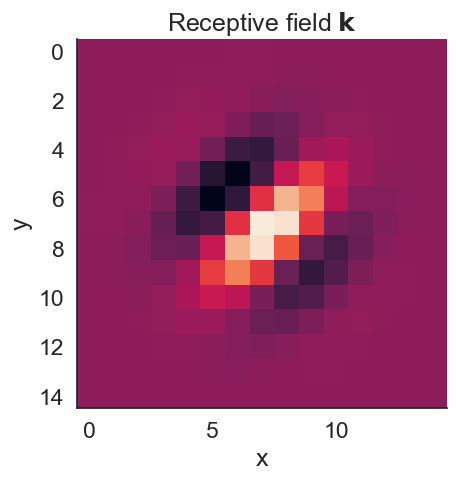

In [6]:
#Creating the true filter by constructing the (gabor) filter

size = (15,15) # size in pixel of our receptive field
mu = (8, 8) # center of the gabor pathc
sigma = (4,4) #size of the gabor patch
angle = 45 # orientation of the gabor patch
frequency = .085 # spatial frequency of the gabor patch
phase = 0 # pahse of the gabor pathc


xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))

# Gaussian envelope
G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
            - np.power(yy - mu[1], 2) / (2. * sigma[1]))

# spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)

K = G * Sn
K /= np.amax(np.abs(K))

plt.imshow(K)
plt.title(r'Receptive field $\bf{k}$')
plt.xlabel('x')
plt.ylabel('y')

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

In [7]:
# generation of the stimulus 

durations = [5., 10., 20., 40., 80., 160., 320., 640]
dt = .1
std_dev = 1
vf_size = (15,15)

Duration: 5.0 seconds
Pearson correlation coefficient: 0.3357016063400128
Duration: 10.0 seconds
Pearson correlation coefficient: 0.5305142708474376
Duration: 20.0 seconds
Pearson correlation coefficient: 0.5967689129421602
Duration: 40.0 seconds
Pearson correlation coefficient: 0.9202142354295754
Duration: 80.0 seconds
Pearson correlation coefficient: 0.9829365708782649
Duration: 160.0 seconds
Pearson correlation coefficient: 0.9890029427419917
Duration: 320.0 seconds
Pearson correlation coefficient: 0.9950258731133661
Duration: 640 seconds
Pearson correlation coefficient: 0.9982252574523695


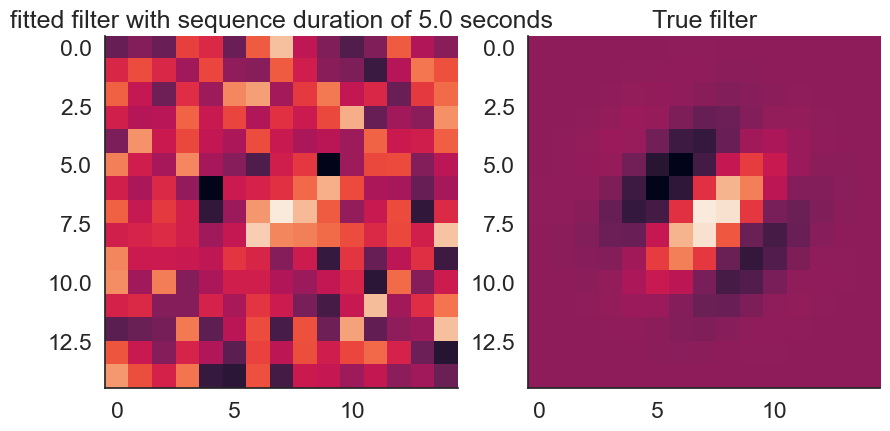

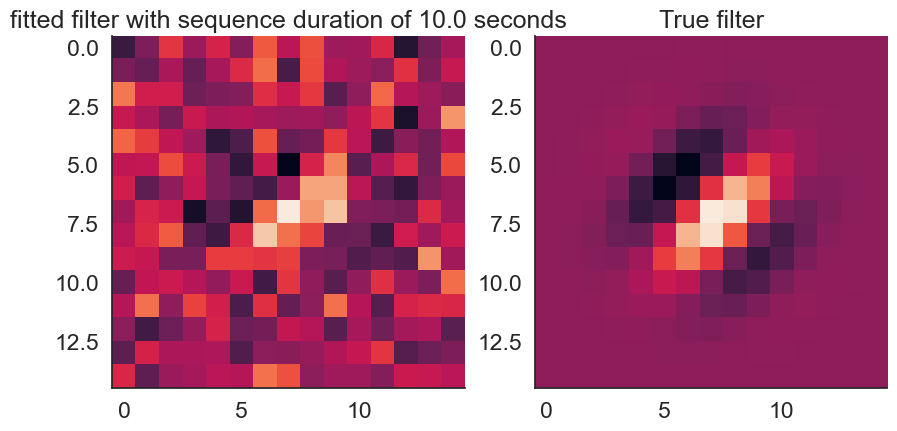

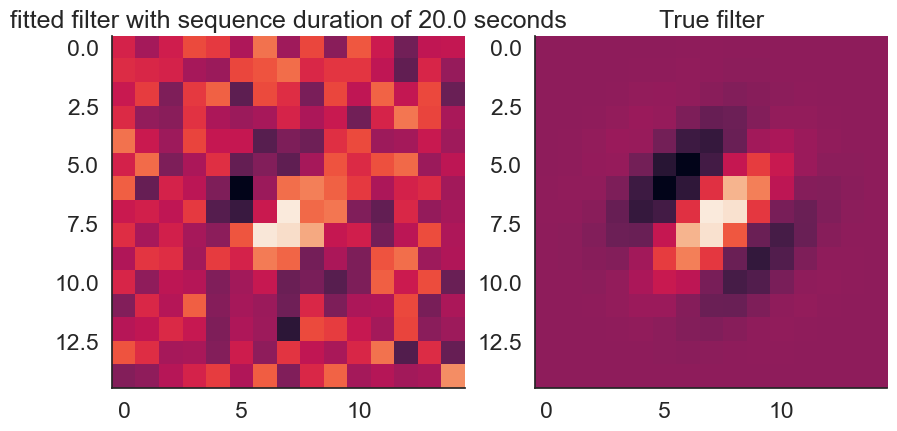

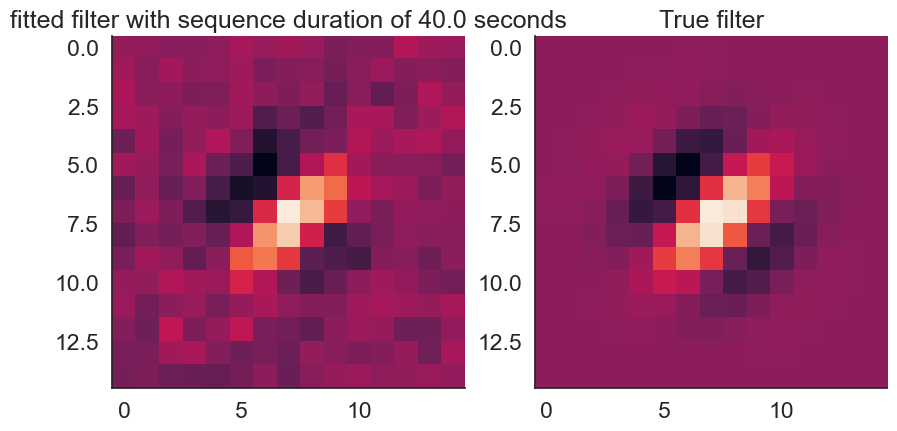

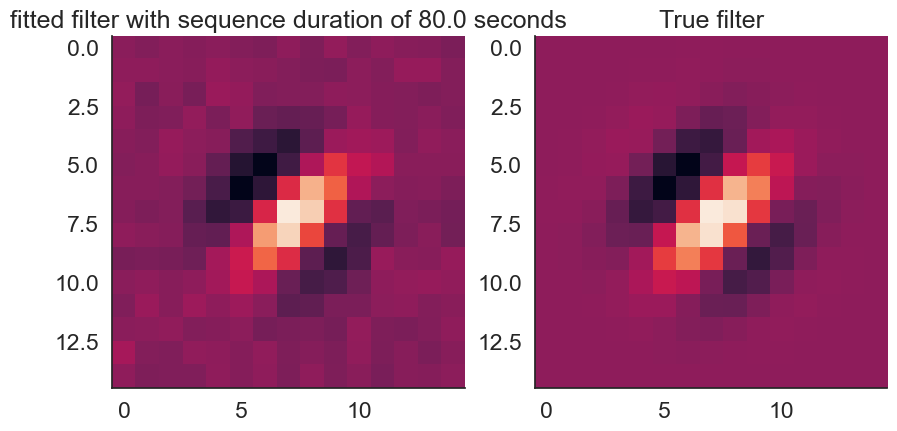

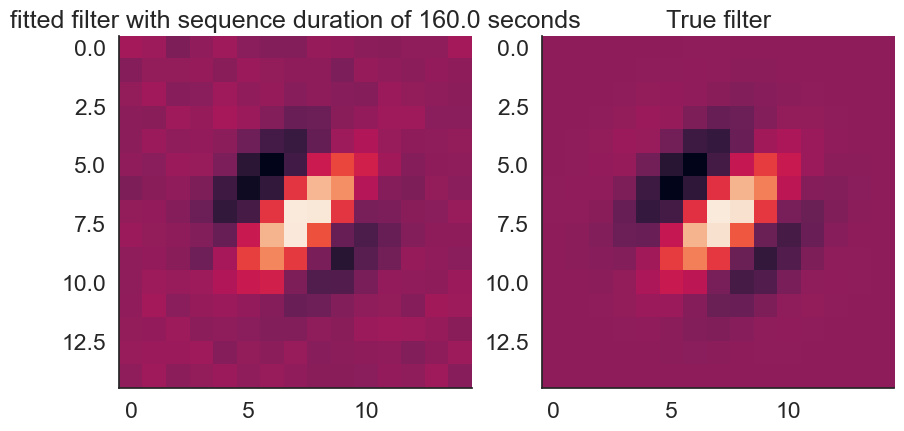

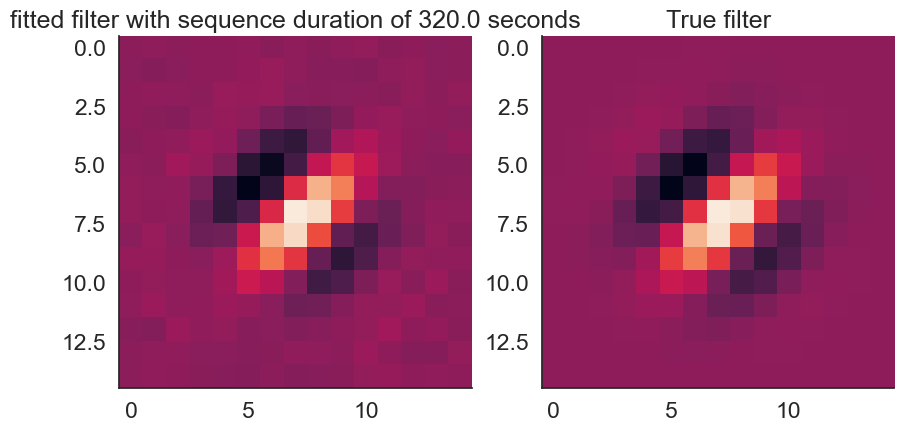

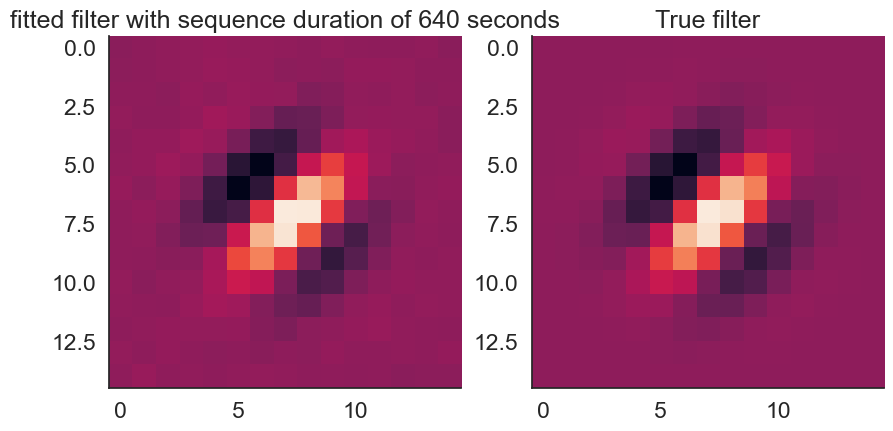

In [8]:
#Setting some necessary contants

noise_variance = 1
# offset is the r_0 that will get implemented into the flattened filter
offset = 2.

# flatten the true (gabor filter) K matrix in to 1d array for convenience
K_flat = K.ravel()
K_flat = np.hstack((K.flat, offset))


#Seeing the effect of different durations of the stimuli on the outcome of the filter estimate
#And acquiring the K_hat for the pearson correlation calculation in the next cell

for duration in durations:
    
    n_bins = round(duration / float(dt))
    
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    
    # flattening the S matrix into a 1d array for convenience
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
    
    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)#gives the output of the linear filter stage

    # 2. nonlinear stage (for a linear model: f -> identity function)
    rate = ks

    # add Gaussian noise centered around the "true" rate for each bin
    
    rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)#recreating the modelled response (rate) formula with the offset integrated into the K
    
    K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
    K_hat = K_hat[:-1].reshape(vf_size)

    #showing the results
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)

    plt.title(f'fitted filter with sequence duration of {duration} seconds')
    plt.imshow(K_hat)
    plt.subplot(1,2,2)
    plt.title('True filter')
    plt.imshow(K)
   
    #Pearson correlation
    
    Pearson_correlation = np.inner(K.ravel(), K_hat.ravel()) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_hat.ravel()))
    print(f"Duration: {duration} seconds")
    print(f'Pearson correlation coefficient: {Pearson_correlation}')

In [9]:
#Setting some variables

durations = [5., 10., 20., 40., 80., 160., 320., 640.]
dt = .1
std_dev = 1
vf_size = (15,15)
spike_rate = 5 # average firing rate 

In [10]:
def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        
        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)

In [11]:
# define functions for minimisation
def cost(k, spike_counts, S,alpha=1):
    #negative loglikelihood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
    
    
def grad(k, spike_counts, S):
    # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)

    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)

Duration: 5.0 seconds
Average spike rate: 5.00 spikes per second

Pearson correlation = 0.11791303748466797
Duration: 10.0 seconds
Average spike rate: 4.70 spikes per second

Pearson correlation = 0.07493984673100328
Duration: 20.0 seconds
Average spike rate: 4.65 spikes per second

Pearson correlation = 0.23195521501842392
Duration: 40.0 seconds
Average spike rate: 4.40 spikes per second

Pearson correlation = 0.5054305088046604
Duration: 80.0 seconds
Average spike rate: 4.58 spikes per second

Pearson correlation = 0.7591678878587161
Duration: 160.0 seconds
Average spike rate: 4.77 spikes per second

Pearson correlation = 0.8369487974950444
Duration: 320.0 seconds
Average spike rate: 4.73 spikes per second

Pearson correlation = 0.9544399048484993
Duration: 640.0 seconds
Average spike rate: 4.68 spikes per second

Pearson correlation = 0.9924212391973907


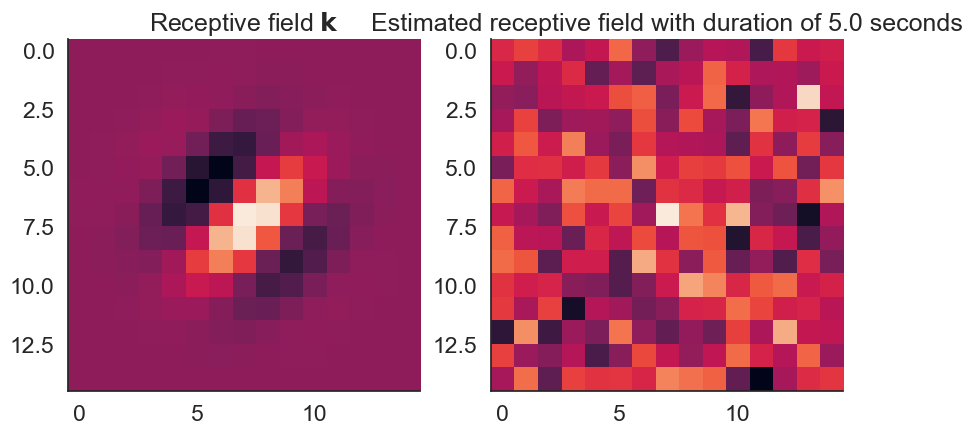

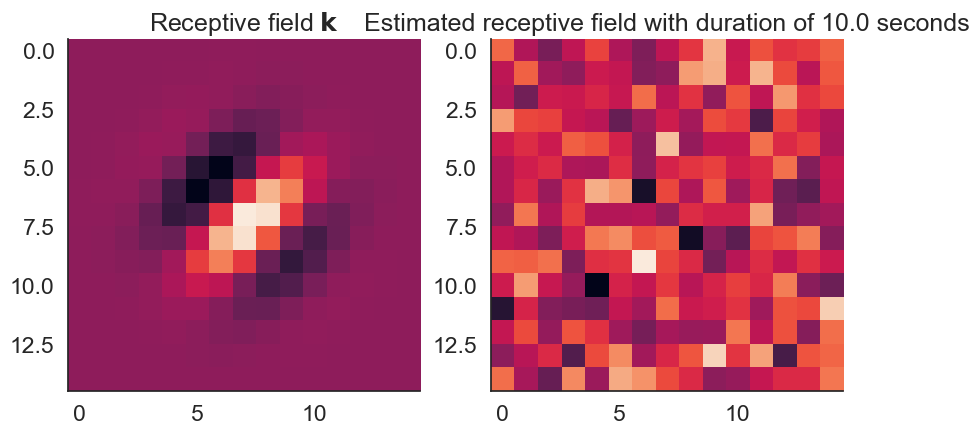

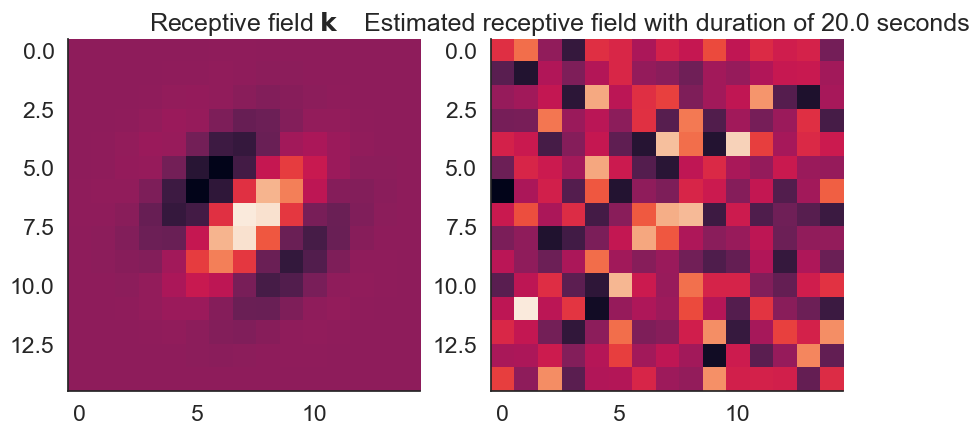

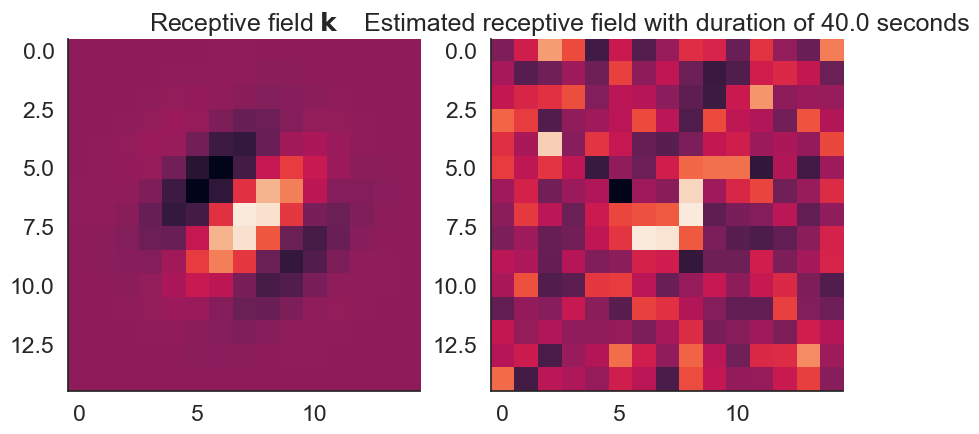

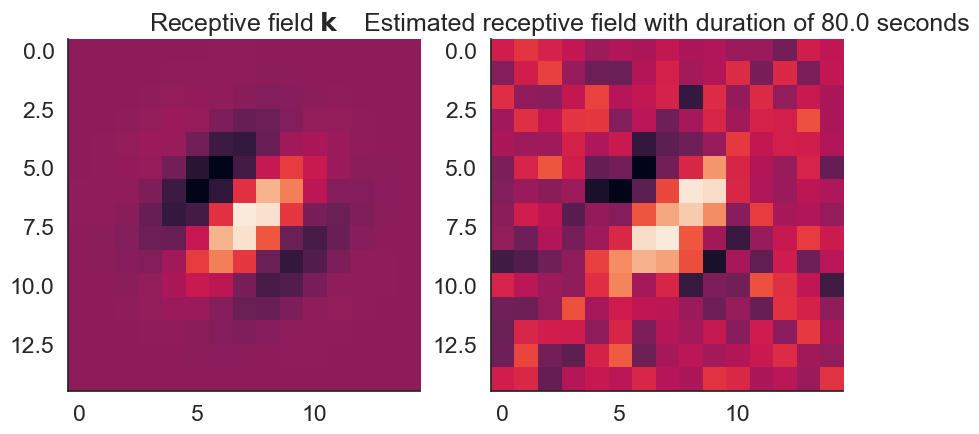

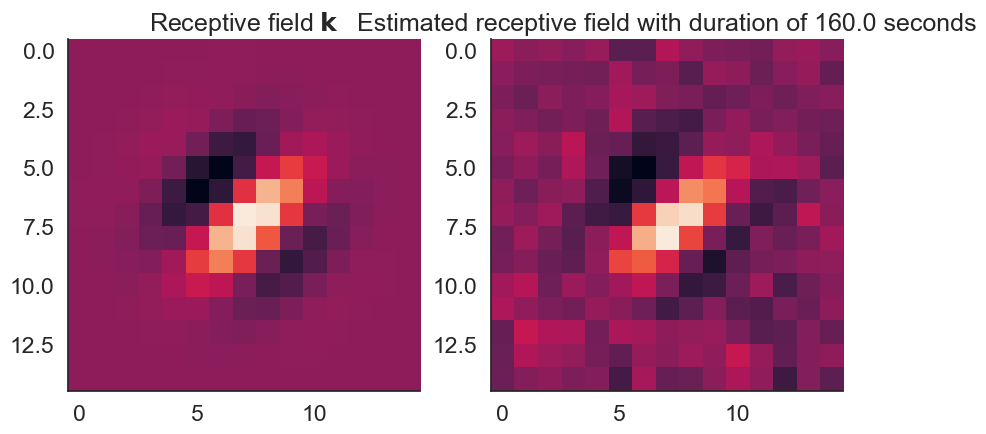

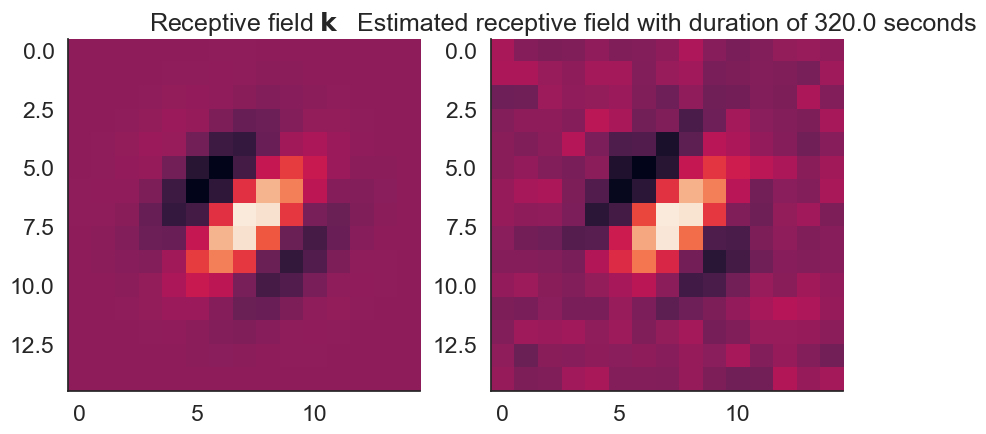

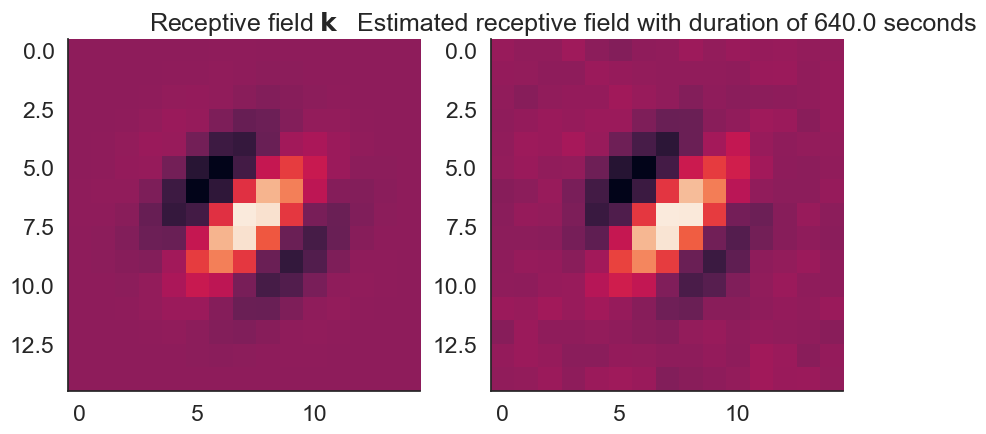

In [13]:
# Iterate over each duration
for duration in durations:
    
    n_bins = round(duration / float(dt))
    
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    
    # flattening the S matrix into a 1d array for convenience
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
    
    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)

    # lamda * dt is the number of spikes in the different bins (but keep in mind that the Poisson process
    # is a stochastic process so the actual number will differ for every draw). Thus, the sum of the product 
    # across all bins gives the expected number of spikes for the whole draw.
    expected_rate = np.sum(lamda * dt) / duration
    lamda *= (spike_rate / expected_rate)
    
    Pearson_correlation_vector = []
    
    for _ in range(10):
        # generate spike times using an inhomogeneous Poisson process
        spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

        # compute spike counts in the different time bins
        spike_counts = np.histogram(spike_times, bins=np.arange(n_bins + 1) * dt)[0]

        #Pearson correlation

        k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
        res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

        K_est = res.x
    
        #Average Pearson correlation of 10 runs
    
        Pearson_correlation = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
        Pearson_correlation_vector.append(Pearson_correlation)
    
    average_Pearson_correlation = sum(Pearson_correlation_vector) / len(Pearson_correlation_vector)
    
    print(f"Duration: {duration} seconds")
    print(f"Average spike rate: {len(spike_times) / duration:.2f} spikes per second\n")
    print(f"Pearson correlation = {average_Pearson_correlation}")
    
    # show result
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.title(r'Receptive field $\mathbf{k}$')
    plt.imshow(K)

    plt.subplot(1,2,2)
    plt.title(f'Estimated receptive field with duration of {duration} seconds')
    plt.imshow(K_est[:-1].reshape(15, 15)) 

The recording duration is critically related to the ability to recover the true receptive field (RF) due to several factors:

1. Signal-to-Noise Ratio (SNR): Longer recording durations typically result in a higher signal-to-noise ratio. More data points mean more information about the neural response, which helps to average out noise and better estimate the true underlying RF.

2. Sampling of Stimulus Space: Longer durations allow for a more comprehensive sampling of the stimulus space. This is crucial for accurately mapping the relationship between stimuli and neural responses, particularly if the stimulus space is large or complex.

3. Statistical Power: Increased recording duration provides more samples, which improves the statistical power of the analysis. This makes it easier to detect small but significant features of the RF and reduces the variance of the estimated parameters.

4. Model Convergence: Many optimization algorithms used to estimate RFs rely on iterative processes that converge more reliably with more data. Short recordings might lead to poor convergence or overfitting, where the model fits the noise instead of the true signal.

### Empirical evidence in the code

In this specific code, the relationship between recording duration and the ability to recover the true RF can be observed empirically by the Pearson correlation between the estimated RF and the true RF. The average Pearson correlation across multiple realizations and durations gives an indication of how well the RF is recovered as the recording duration increases.

From this setup, the process to observe this relationship involves:
1. Generating spike times using a Poisson process for each duration.
2. Estimating the RF using optimization techniques.
3. Calculating the Pearson correlation between the estimated and true RFs.
4. Averaging these correlations across multiple realizations.

### Expected outcomes

- Short Durations: With shorter recording durations (e.g., 5 or 10 seconds), you might observe lower and more variable Pearson correlations due to insufficient data to reliably estimate the RF.
- Intermediate Durations: As the duration increases (e.g., 40 to 80 seconds), the correlations are expected to improve as the estimate of the RF becomes more accurate and consistent.
- Long Durations: With very long durations (e.g., 160 seconds and beyond), the Pearson correlations should plateau, indicating that the estimate of the RF is now very close to the true RF. Further increases in duration might offer diminishing returns.

Plotting the average Pearson correlation as a function of duration helps visualize this relationship. The plot typically shows an increasing trend that levels off, illustrating how longer recordings provide more reliable estimates of the true RF up to a certain point.

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

In [14]:
# Setting some prerequisites
noise_variances = [0, 2, 4, 6, 8, 10, 12, 14, 16]
duration = 100.
dt = .1
std_dev = 1
vf_size = (15,15)
n_bins = round(duration / float(dt))
offset = 2

#Making 500 (n_bins) slides of random data pulled from a gaussian distribution in a 15x15 pixels (vf_size) sheets
S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

# flatten the true (gabor filter) K matrix in to 1d array for convenience
K_flat = K.ravel()
K_flat = np.hstack((K.flat, offset))

# flattening the S matrix into a 1d array for convenience
S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


# 1. linear stage
ks = np.dot(K_flat, S_flat.T)#gives the output of the linear filter stage

# 2. nonlinear stage (for a linear model: f -> identity function)
rate = ks

Noise Variance: 0, Standard Deviation of Pearson Correlations: 0.0
Noise Variance: 2, Standard Deviation of Pearson Correlations: 0.0031859585430279755
Noise Variance: 4, Standard Deviation of Pearson Correlations: 0.005650349044600323
Noise Variance: 6, Standard Deviation of Pearson Correlations: 0.009691781397575554
Noise Variance: 8, Standard Deviation of Pearson Correlations: 0.01021935748434261
Noise Variance: 10, Standard Deviation of Pearson Correlations: 0.014018588572880963
Noise Variance: 12, Standard Deviation of Pearson Correlations: 0.011610989265770269
Noise Variance: 14, Standard Deviation of Pearson Correlations: 0.020654984907845425
Noise Variance: 16, Standard Deviation of Pearson Correlations: 0.01124771423115992


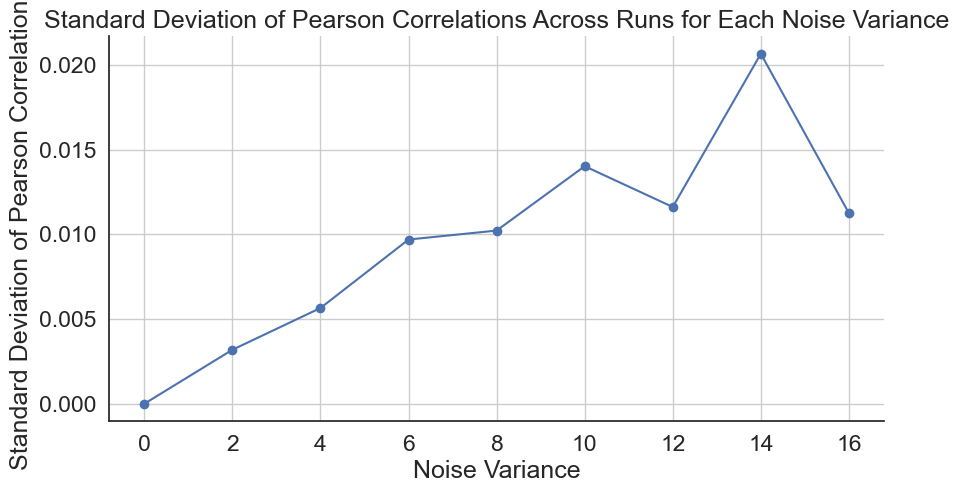

In [15]:
pearson_correlations = []
correlation_std_devs = []

for noise_variance in noise_variances:
    
    K_hat_vector = []
    pearson_corr_vector = []
    
    for _ in range(10):
        
        neuron_rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)

        K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ neuron_rate)
        K_hat = K_hat[:-1].reshape(vf_size)
        K_hat_vector.append(K_hat)
        
        pearson_correlation = np.inner(K.ravel(), K_hat.ravel()) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_hat.ravel()))
        pearson_corr_vector.append(pearson_correlation)
        
    pearson_correlations.append(pearson_corr_vector)

    correlation_std_dev = np.std(pearson_corr_vector)
    correlation_std_devs.append(correlation_std_dev)

    print(f"Noise Variance: {noise_variance}, Standard Deviation of Pearson Correlations: {correlation_std_dev}")

plt.figure(figsize=(10, 5))
plt.plot(noise_variances, correlation_std_devs, marker='o', linestyle='-', color='b')
plt.xlabel('Noise Variance')
plt.ylabel('Standard Deviation of Pearson Correlations')
plt.title('Standard Deviation of Pearson Correlations Across Runs for Each Noise Variance')
plt.grid(True)
plt.show()

## Exercise 3
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 




In the context of a Poisson Generalized Linear Model (GLM) for neural responses, the likelihood of observing a set of spike counts $ R = {r_t} $ given the stimulus $S = {\mathbf{s}_t}$ and the receptive field $\mathbf{k}$ is given by:

$ P(R|S, \mathbf{k}) = \prod_{t=1}^{T} P(r_t|\mathbf{s}_t, \mathbf{k}) $

For a Poisson process, the probability of observing $r_t$ spikes at time $t$ given the stimulus $\mathbf{s}_t$ and parameters $\mathbf{k}$ is:

$ P(r_t|\mathbf{s}_t, \mathbf{k}) = \frac{\lambda_t^{r_t} e^{-\lambda_t}}{r_t!} $

where $\lambda_t = f(\mathbf{k} \cdot \mathbf{s}_t)$ and $f$ is the nonlinear function that converts the linear prediction to the spike rate, often chosen as the exponential function, i.e., $\lambda_t = \exp(\mathbf{k} \cdot \mathbf{s}_t)$.

Taking the log-likelihood:

$ \log P(R|S, \mathbf{k}) = \sum_{t=1}^{T} \log P(r_t|\mathbf{s}_t, \mathbf{k}) $

$ \log P(R|S, \mathbf{k}) = \sum_{t=1}^{T} \left( r_t \log \lambda_t - \lambda_t - \log r_t! \right) $

Substituting $\lambda_t = \exp(\mathbf{k} \cdot \mathbf{s}_t)$:

$ \log P(R|S, \mathbf{k}) = \sum_{t=1}^{T} \left( r_t (\mathbf{k} \cdot \mathbf{s}_t) - \exp(\mathbf{k} \cdot \mathbf{s}_t) - \log r_t! \right) $

To maximize the log-likelihood with respect to $\mathbf{k}$, we need to consider which terms depend on $\mathbf{k}$:

- The term $r_t (\mathbf{k} \cdot \mathbf{s}_t)$ depends on $\mathbf{k}$.
- The term $-\exp(\mathbf{k} \cdot \mathbf{s}_t)$ depends on $\mathbf{k}$.
- The term $\log r_t!$ does not depend on $\mathbf{k}$, and hence can be ignored in the optimization process.

Thus, the simplified log-likelihood function that we need to maximize with respect to $\mathbf{k}$ is:

$\log P(R|S, \mathbf{k}) = \sum_{t=1}^{T} \left( r_t (\mathbf{k} \cdot \mathbf{s}_t) - \exp(\mathbf{k} \cdot \mathbf{s}_t) \right)$

Ignoring the constant term $\sum_{t=1}^{T} \log r_t!$:

$ \log P(R|S, \mathbf{k}) \propto \sum_{t=1}^{T} \left( r_t (\mathbf{k} \cdot \mathbf{s}_t) - \exp(\mathbf{k} \cdot \mathbf{s}_t) \right) $

This is the log-likelihood function that should be used for maximizing with respect to $\mathbf{k}$.

## Exercise 4
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 

#### Part A

In [22]:
# setting some values

durations = [10., 20., 50., 100., 200.]
dt = .1
std_dev = 1
vf_size = (15,15)
spike_rate = 5 # average firing rate 
# Iterate over each duration

In [25]:
# Iterate over each duration

Pearson_correlations = []

for duration in durations:
    
    n_bins = round(duration / float(dt))
    
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    
    # flattening the S matrix into a 1d array for convenience
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
    
    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)

    # lamda * dt is the number of spikes in the different bins (but keep in mind that the Poisson process
    # is a stochastic process so the actual number will differ for every draw). Thus, the sum of the product 
    # across all bins gives the expected number of spikes for the whole draw.
    expected_rate = np.sum(lamda * dt) / duration
    lamda *= (spike_rate / expected_rate)
    

    # generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times, bins=np.arange(n_bins + 1) * dt)[0]

    #Pearson correlation

    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

    K_est = res.x
    
    #Average Pearson correlation of 10 runs
    
    Pearson_correlation = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
    
    Pearson_correlations.append(Pearson_correlation)
    
    # show result
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.title(r'Receptive field $\mathbf{k}$')
    plt.imshow(K)

    plt.subplot(1,2,2)
    plt.title(f'Estimated receptive field with duration of {duration} seconds')
    plt.imshow(K_est[:-1].reshape(15, 15)) 

TypeError: cost() missing 1 required positional argument: 'dt'

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

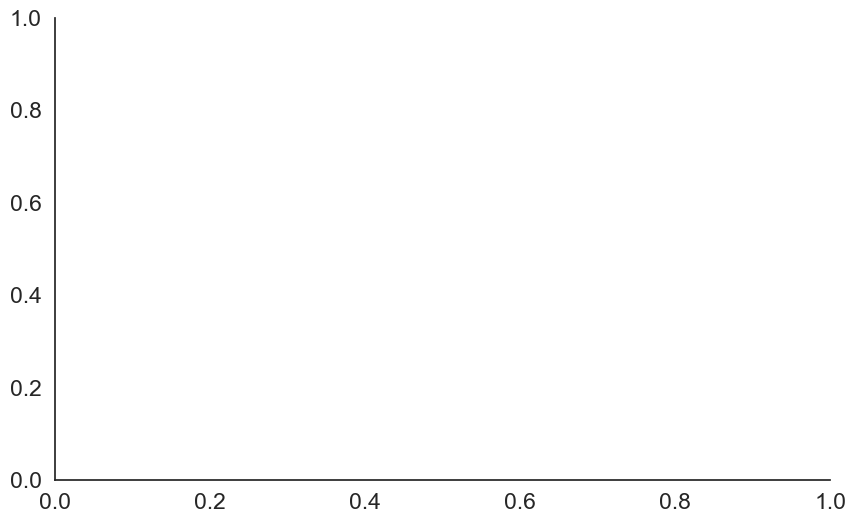

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(durations, Pearson_correlations, marker='o', linestyle='-')
plt.xlabel('Duration of stimulus (s)')
plt.ylabel('Pearson Correlation')
plt.show()

#### Part B

In [26]:
# setting some values

duration = 100.
dt = .1
std_dev = 1
vf_size = (15,15)
spike_rates = [1, 2, 5, 10, 20, 50, 100] # average firing rate 
n_bins = round(duration / float(dt))
    
S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    
# flattening the S matrix into a 1d array for convenience
S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
    
# 1. linear stage
ks = np.dot(K_flat, S_flat.T)

In [27]:
# Iterate over each spike rate

Pearson_correlations = []

for spike_rate in spike_rates:

    # 2. nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)

    # lamda * dt is the number of spikes in the different bins (but keep in mind that the Poisson process
    # is a stochastic process so the actual number will differ for every draw). Thus, the sum of the product 
    # across all bins gives the expected number of spikes for the whole draw.
    expected_rate = np.sum(lamda * dt) / duration
    
    lamda *= (spike_rate / expected_rate)
    

    # generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times, bins=np.arange(n_bins + 1) * dt)[0]

    #Pearson correlation

    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

    K_est = res.x
    
    #Average Pearson correlation of 10 runs
    
    Pearson_correlation = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
    
    Pearson_correlations.append(Pearson_correlation)
    
    # show result
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.title(r'Receptive field $\mathbf{k}$')
    plt.imshow(K)

    plt.subplot(1,2,2)
    plt.title(f'Estimated receptive field with spike rate of {spike_rate}')
    plt.imshow(K_est[:-1].reshape(15, 15)) 

TypeError: cost() missing 1 required positional argument: 'dt'

ValueError: x and y must have same first dimension, but have shapes (7,) and (0,)

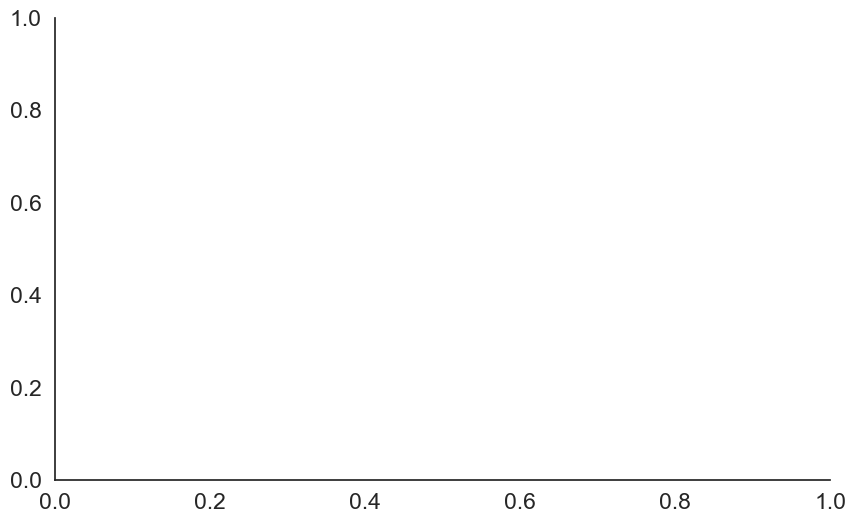

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(spike_rates, Pearson_correlations, marker='o', linestyle='-')
plt.xlabel('Spike rate')
plt.ylabel('Pearson Correlation')
plt.show()